# Feature Engineering

This section outlines some steps taken to transform the data in an attempt to improve model performance. A series of EDA methods were applied were possible to select appropriate transformations. [TIME SERIES ANALYSIS WITH PANDAS](https://ourcodingclub.github.io/tutorials/pandas-time-series/#resampling), [Fitting time series regression models](https://people.duke.edu/~rnau/timereg.html), and [6 Powerful Feature Engineering Techniques For Time Series Data (using Python)](https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/) were referenced to guide the process.

In [1]:
#Load the neccessary libraries, others will be imported were applicable
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow import keras
from scipy import stats
import seaborn as sns

## Import the dataset

In [2]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train=pd.read_pickle("../input/ubiquant-market-prediction-half-precision-pickle/train.pkl") #reduced memory usage

CPU times: user 299 ms, sys: 1.32 s, total: 1.62 s
Wall time: 13.7 s


## Create Simulated DateTime Index

#### Most of the time series datat transformations require a valied DateTime or PeriodTime index. Because the data does not specify one, the time_id column was used to create a dummy variable for Time indexing. It assumes a continous time-period of daily frequency.

In [3]:
def create_datetime(df,index):
    """ Takes the time_id column of the dataframe to simulate a datetime object
    
     Args: a dataframe and the name of the index with the time-like data

     Returns: dataframe with a datetime index
    
    """
    period=max(df[index]) - min(df[index]) + 2
    dti=pd.date_range(start="2000-01-01", periods=period, freq='D')
    times=[time for time in range(period)]
    data_index_dict=dict(zip(times, dti))
    time_id=df[index].unique()
    df['date_time']=df[index]
    df['date_time'].replace(data_index_dict, inplace=True)
    df['date_time'] =  pd.to_datetime(df['date_time']) 
    
create_datetime(train, 'time_id')
train = train.set_index('date_time')
#train.head()
gc.collect()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


0

### Inspect the frequency of investment_id

<AxesSubplot:>

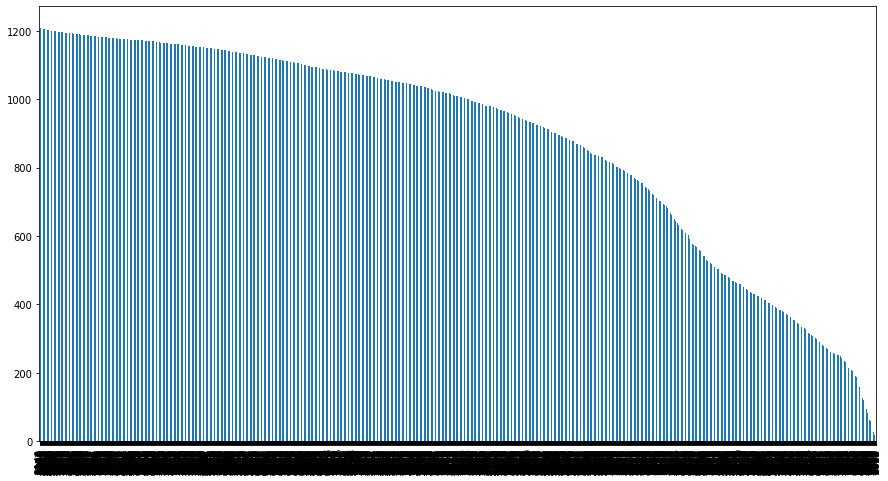

In [4]:
#Count the occurence of each uqie investment_id and plot the frequency
unique=train['investment_id'].value_counts()
unique.plot.bar(figsize=(15,8))

From this barplot, we can see that some of the investment_id's are underepresented in the datset. We may attempt to remove them to seeif our model's accuracy and/or predictive power will improve

### Are any of the features f_0 to f_299 strongly correlated with the target?

First we inspect the linear relationship of some random features

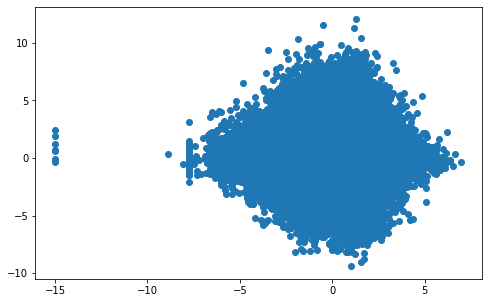

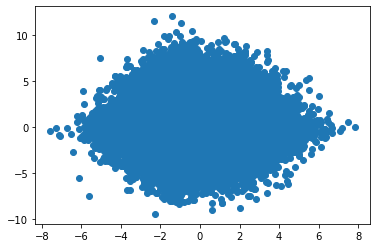

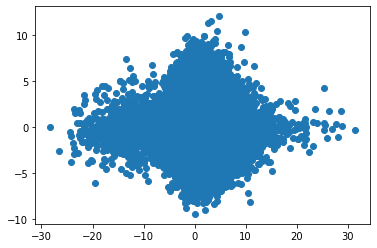

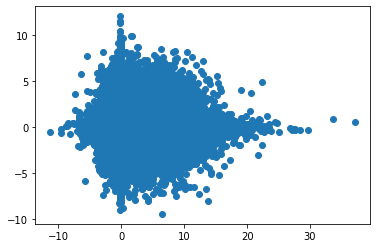

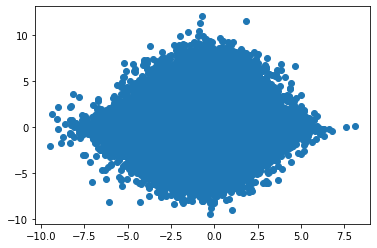

11905

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
#Draw scatterplots of random features
import random as r
random= [r.randint(0,300) for i in range(5)]
random
for i in random:
    plt.scatter(train[f'f_{i}'], train['target'])
    plt.title(f'Scatterplot of f_{i} with target')
    plt.show()

gc.collect()

We then check to see if any of the features are at least mdoerately correlated with the target, Cut-off of 0.5 in either direction

In [6]:
#Check if any of the features f_0 to f_299 are at lest wekly correlated with the target using pearson's r
correlations=[]
feature_columns=[]
for col in train.columns[2:-1]:
    coef = np.corrcoef(train['target'], train[col])[0][1]
    correlations.append(coef)
    feature_columns.append(col)
    
target_feature_coeff=pd.concat([pd.Series(feature_columns), pd.Series(correlations)],axis=1)
for cor in correlations:
    if cor >0.5 or cor <-0.5:
        print(f'{len({cor})} features are correlated with target')

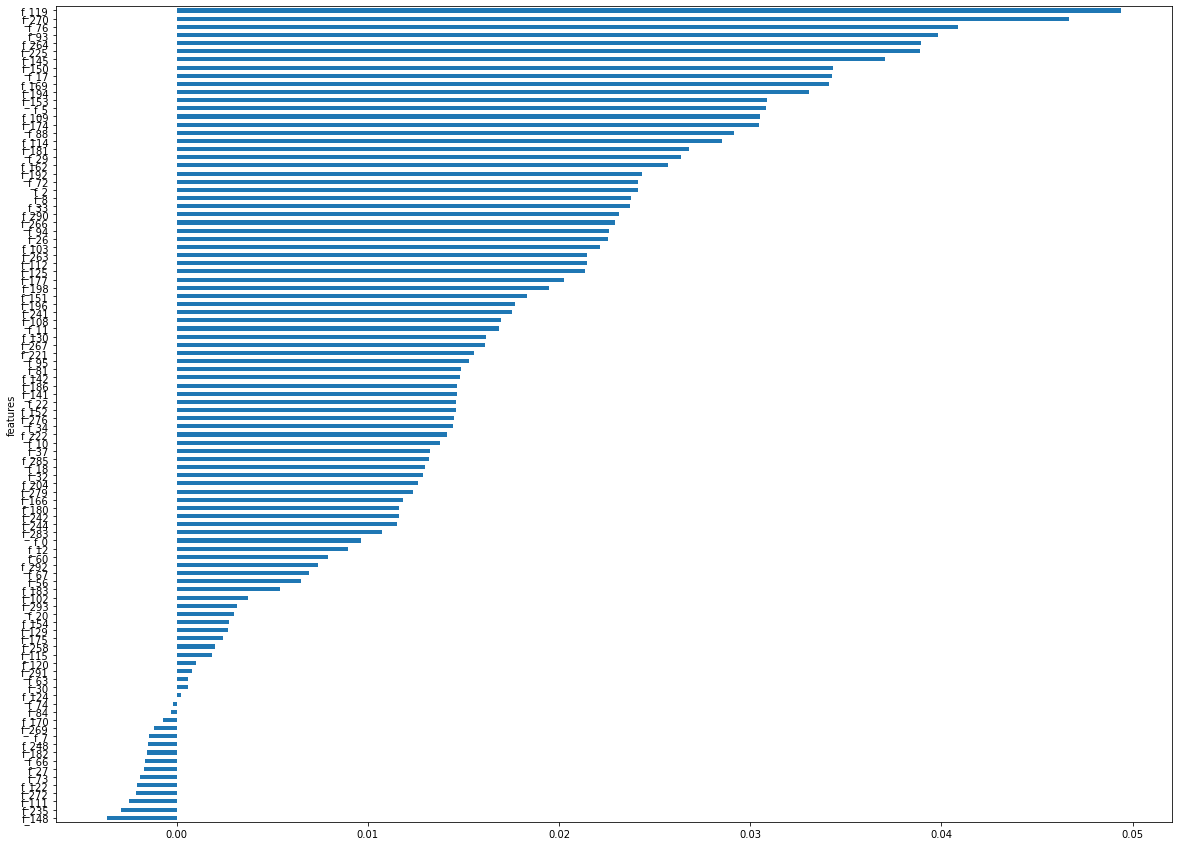

In [7]:
#rename the columns in our correlations_target df
target_feature_coeff['features']=target_feature_coeff[0]
target_feature_coeff['coeff']=target_feature_coeff[1]
target_feature_coeff.drop([0,1], axis=1)

#visualize the importance of features based on pearson's r
i = target_feature_coeff['features']
feat_importances = pd.Series(correlations, index=i)
feat_importances.nlargest(100).plot(kind='barh', figsize=(20, 15)).invert_yaxis()
plt.show()

### We'll check if the features are autocorrelated and see if it changes with resampling at different time lags

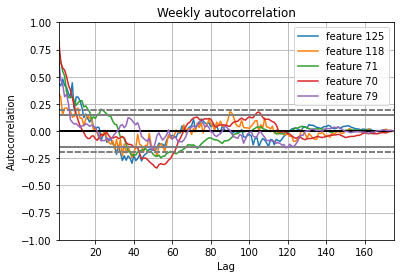

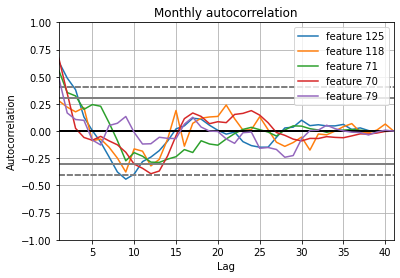

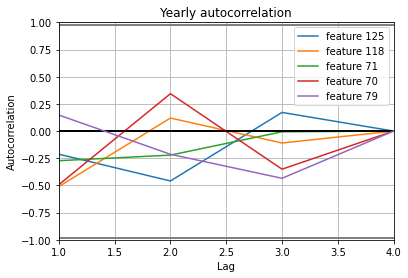

In [13]:
#Examine how autocorrelation of random features changes with size of our simulated lag times
import random as r
random= [r.randint(0,300) for i in range(5)]
random
for i in random:
    df = train[f'f_{i}']
    pd.plotting.autocorrelation_plot(df.resample('1w').median(), label=(f'feature {i}'))
    plt.title(f"Weekly autocorrelation of feature f_{i}")
plt.show()



for i in random:
    df = train[f'f_{i}'] 
    pd.plotting.autocorrelation_plot(df.resample('1m').median(), label=(f'feature {i}'))
    plt.title(f'Monthly autocorrelation of feature f_{i}')
plt.show()


for i in random:
    df = train[f'f_{i}'] 
    pd.plotting.autocorrelation_plot(df.resample('1y').median(), label=(f'feature {i}'))
    plt.title(f'Yearly autocorrelation of feature f_{i}')
plt.show()


#### It is highly dependent on the feature but there is some correlation which smoothes out the longer the lag

### Conduct Adfuller test for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


In [ ]:
for column in train.columns:
    adfuller_test(train, column)

Results of Dickey-Fuller Test for column: investment_id


Running out of memory while computing adf. Unable to use results.

### First we attempted a Min-Max Scaling. Because the data has negative values, mathematical transformations often utilised in time series anlysis could not be used e.g log transformation

In [ ]:
#Normalize the data using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled= scaler.fit_transform(X)
gc.collect()

The model performance dropped from 0.149 to 0.137 with scaled data

### Create a lagged dataframe and feed it to the model for training

In [5]:
#Copy the dataframe
df_lagged = train.copy()
#trailing_window_size = 2
df_lagged = pd.concat([df_lagged.shift(1)], axis=1)
df_lagged = df_lagged.fillna(0) #filling with 0's appears to have less of an effect on reducing model performance than mathematical interpolation
df_lagged.head()
gc.collect()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-01,1.0,0.0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
2000-01-01,2.0,0.0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2000-01-01,6.0,0.0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
2000-01-01,7.0,0.0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453


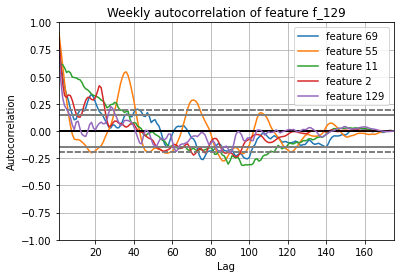

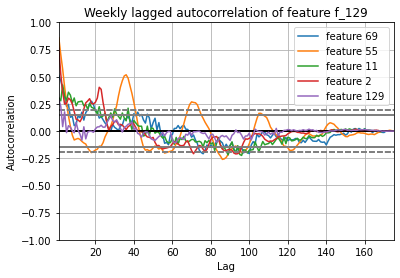

In [15]:
#compare original and lagged data with weekly resampling to check for any change
for i in random:
    original=train[f'f_{i}']
    pd.plotting.autocorrelation_plot(original.resample('1w').median(), label=(f'feature {i}'))
    plt.title(f"Weekly autocorrelation of feature f_{i}")
plt.show()
    
for i in random:
    df = df_lagged[f'f_{i}']
    pd.plotting.autocorrelation_plot(df.resample('1w').median(), label=(f'feature {i}'))
    plt.title(f"Weekly lagged autocorrelation of feature f_{i}")
plt.show()


#### The autocorrelation hasn't changed much. No competition submission was made on lagged data alone

### Difference the data to control for noise

In [8]:
#create a dataset from the differences per increment and pad the first row with 0's
differenced_data= train.diff(axis = 0, periods = 1)
differenced_data=differenced_data.fillna(0)
differenced_data.head()
#del(differenced_data)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-01,1.0,0.0,-0.121582,-0.627930,1.144531,-0.995117,0.009766,2.185547,0.461914,-0.096680,...,2.007812,-0.934570,0.000000,0.000000,-0.300781,0.000000,0.115234,-0.686523,-0.665039,0.069702
2000-01-01,4.0,0.0,-0.416992,1.129883,-0.174316,0.008789,0.263184,-2.855469,-0.448242,-2.259766,...,0.000000,0.182617,-2.039062,-2.001953,0.168579,0.000000,0.317383,0.860352,0.586914,0.799805
2000-01-01,1.0,0.0,-2.738281,-0.627441,1.306641,0.001465,-0.655762,0.267090,-0.201172,1.424805,...,0.000000,0.285400,0.000000,2.001953,-0.389648,1.191406,-0.170898,1.265625,-1.017578,-1.632812
2000-01-01,1.0,0.0,3.185547,-0.250977,0.455078,0.022949,-0.031250,0.073242,-1.724609,0.931641,...,0.000000,-0.474854,0.000000,0.000000,0.020508,0.000000,1.537109,0.194336,0.035645,0.532715


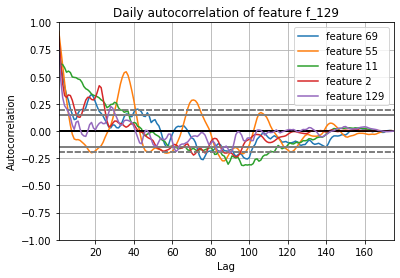

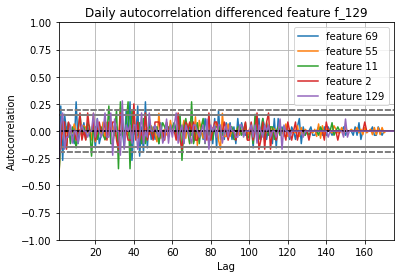

In [16]:
#Visualise change in autocorration after differencing
for i in random:
    df = train[f'f_{i}']
    pd.plotting.autocorrelation_plot(df.resample('1w').mean(), label=(f'feature {i}'))
    plt.title(f"Daily autocorrelation of feature f_{i}")
plt.show()
for i in random:
    diff = differenced_data[f'f_{i}']
    pd.plotting.autocorrelation_plot(diff.resample('1w').mean(), label=(f'feature {i}'))
    plt.title(f"Daily autocorrelation differenced feature f_{i}")
plt.show()

### differencing appears to have the biggest effect on stationarity. 

In [19]:
def inverse_diff(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[col].replace(actual_df[col].iloc[-1] + df_res[str(col)].cumsum())
    return df_res

#### Although the model was able to train on differenced data, the predictions were inaccurate as we were unable to apply differencing and inversing to the test_df as it does not have a 'time_id" column and raised a keyerror.
Differencing resulted in a score of 0.138 a drop from the 0.149 of the untempered datat

### Resample data using the simulated Date-time to weekly. 

In [11]:
#Resample dataframe by averaging to period=7 

for column in train.columns:
    train[column]=train[column].resample('W').median()
    train[column]=train[column].interpolate(method ='linear', limit_direction ='backward')

Let's see what that looks like.

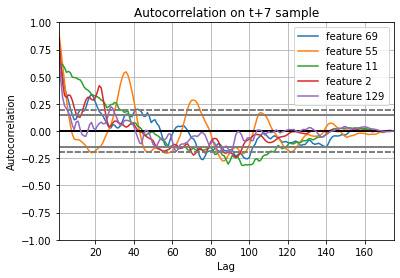

In [14]:
#Inspect the autocorrelation in the new dataframe
for i in random:
    df = train[f'f_{i}']
    #diff = train[f'f_{i}']
    pd.plotting.autocorrelation_plot(df.resample('w').median(), label=(f'feature {i}'))
    plt.title("Autocorrelation on t+7 sample")
plt.show()


### Feature Engineering Summary

More tests are needed to examine the data inorder to apply feature extesnsion and selection criteria to improve model performance. We were unable to leverage many feature engineering tools particulary the [scikit](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html) library  due to computational limits arsing from the size of the dataframe.